# Sketch to NormalMap Preprocessing

### Read dataset state.json -> find all .obj -> record pathes

In [4]:
import json
import os
from pathlib import Path

# Path to the state.json file
state_json_path = "../dataset/auto_building_dataset/auto_building_dataset.4d71dc38198d4baa8e60d70e1db84469/artifacts/state/state.json"

# Read the state.json file
print("Reading state.json file...")
with open(state_json_path, 'r') as f:
    state_data = json.load(f)

print(f"State data loaded successfully. Type: {type(state_data)}")

# Extract all .obj file paths
obj_paths = []

# Function to recursively search for .obj files in the JSON structure
def find_obj_files(data, current_path=""):
    if isinstance(data, dict):
        for key, value in data.items():
            if key == "relative_path" and isinstance(value, str) and value.endswith('.obj'):
                obj_paths.append(value)
            else:
                find_obj_files(value, f"{current_path}.{key}" if current_path else key)
    elif isinstance(data, list):
        for i, item in enumerate(data):
            find_obj_files(item, f"{current_path}[{i}]" if current_path else f"[{i}]")

# Search for .obj files
find_obj_files(state_data)

print(f"\nFound {len(obj_paths)} .obj files:")
print("=" * 50)

# Display all .obj file paths
for i, obj_path in enumerate(obj_paths, 1):
    print(f"{i:4d}. {obj_path}")

print(f"\nAll .obj file paths saved to: {output_file}")
print(f"Total .obj files found: {len(obj_paths)}")

# Also create a list for further processing
obj_paths_list = obj_paths.copy()
print(f"\nFirst 10 .obj files:")
for i, path in enumerate(obj_paths_list[:10], 1):
    print(f"  {i}. {path}")

Reading state.json file...
State data loaded successfully. Type: <class 'dict'>

Found 1364 .obj files:
   1. Asian_Block/AsianBlock_Appartment_B016.obj
   2. Tibet_House/._GROUND.obj
   3. House_Medieval_Gate/House_Medieval_Gate.obj
   4. Castle/Castle_LedgeTop001.obj
   5. Asian/._AsianBlock_Appartment_B014.obj
   6. Venice_House/Venice_Doors003.obj
   7. House_Medieval_Wall/MedievalWoddenDoor.obj
   8. House_Medieval_9.obj
   9. HouseOld/._HouseOld_Leaking_Decals002.obj
  10. Tibet_House/._Tibet_WindowsRed_A.obj
  11. Venice_Palace/Venice_Facade_A.obj
  12. Building_NeoClassical/NeoClassic_Roof_Edge.obj
  13. House_Medieval_Wall/Chimney_Old.obj
  14. Venice_Palace/Venice_Palace_B.obj
  15. Sci_Fi/._Sci_Fi_B.obj
  16. Castle/._GROUND.obj
  17. HauntedMansion/._Haunted_Door.obj
  18. Venice_House_7.obj
  19. Venice_Palace/Venice_Corner_A.obj
  20. Venice_House/Venice_Arches_A.obj
  21. Modular_Roof_Demo/._ModularRoofDemo_WallsGrid002.obj
  22. Venice_Palace/._Venice_Palace_B.obj
  23.

### Separate to props and buildings

In [ ]:
from pathlib import Path

# Ensure we have the list of obj paths in memory; otherwise load from the file
try:
    obj_paths_source = obj_paths_list
except NameError:
    raise RuntimeError("No obj_paths_list in memory")

# Split into buildings (root-level files) and props (inside subdirectories)
building_paths = []
props_paths = []

for p in obj_paths_source:
    if "/" in p:
        props_paths.append(p)
    else:
        building_paths.append(p)

# Deduplicate while preserving order
building_paths = list(dict.fromkeys(building_paths))
props_paths = list(dict.fromkeys(props_paths))

# Write outputs in the current directory
buildings_out = "paths_building_models.txt"
props_out = "paths_props_models.txt"

with open(buildings_out, 'w') as f:
    for p in building_paths:
        f.write(p + "\n")

with open(props_out, 'w') as f:
    for p in props_paths:
        f.write(p + "\n")

print(f"Building models: {len(building_paths)} saved to {buildings_out}")
print(f"Props models:    {len(props_paths)} saved to {props_out}")

# Preview a few examples
print("\nSample buildings:")
for s in building_paths[:10]:
    print("  ", s)
print("\nSample props:")
for s in props_paths[:10]:
    print("  ", s)


Building models: 122 saved to paths_building_models.txt
Props models:    1242 saved to paths_props_models.txt

Sample buildings:
   House_Medieval_9.obj
   Venice_House_7.obj
   Tatooine_House_1.obj
   Asian_Block_1.obj
   Venice_House_2.obj
   ._House_Medieval_8.obj
   ._Castle_9.obj
   Tatooine_House_10.obj
   Modular_Roof_Demo_1.obj
   Asian_2.obj

Sample props:
   Asian_Block/AsianBlock_Appartment_B016.obj
   Tibet_House/._GROUND.obj
   House_Medieval_Gate/House_Medieval_Gate.obj
   Castle/Castle_LedgeTop001.obj
   Asian/._AsianBlock_Appartment_B014.obj
   Venice_House/Venice_Doors003.obj
   House_Medieval_Wall/MedievalWoddenDoor.obj
   HouseOld/._HouseOld_Leaking_Decals002.obj
   Tibet_House/._Tibet_WindowsRed_A.obj
   Venice_Palace/Venice_Facade_A.obj


### Create sketches and normalmaps from the .objs

In [43]:
import os
import subprocess

# Configuration
dataset_prefix = "../dataset/auto_building_dataset/auto_building_dataset.4d71dc38198d4baa8e60d70e1db84469/artifacts/data_001/dataset.4d71dc38198d4baa8e60d70e1db84469.atglsnbm/"
converter_path = "../../bin/converter_cli"
normal_map_dataset = "../dataset/normal_map_dataset"
sketch_dataset = "../dataset/sketch_dataset"

# Camera parameters (changeable)
camera_pos = "(10,10,10)"
camera_fov = 10
image_width = 1024
image_height = 1024

# Read building model paths
with open("paths_building_models.txt", 'r') as f:
    building_paths = [line.strip() for line in f.readlines()]

print(f"Found {len(building_paths)} building models")

# Generate 20 different camera positions and FOV variations
import numpy as np

# Create 20 different camera positions around the model
# 360-degree rotation around Y axis (XZ plane) with Y height variations
base_pos = np.array([10, 10, 10])
camera_variations = []

iterations = 25
# Generate 20 positions: 360-degree rotation around Y axis
for i in range(iterations):
    # Calculate angle for full 360-degree rotation
    angle = (i * np.pi*2) / (iterations)  # 0 to 2π in 20 steps
    
    # Position camera in XZ plane at fixed distance from origin
    # Vary X and Z coordinates to create circular motion around Y axis
    x = 1000*np.cos(angle)  # Circle radius of 10
    z = 1000*np.sin(angle)  # Circle radius of 10
    
    # Vary Y height between 5 and 15 for different viewing angles
    camera_variations.append((x,abs(x*0.5)-100,z))


# Generate FOV variations from 5 to 80 degrees for more dramatic differences
fov_variations = [10]

print(f"Generated {len(camera_variations)} camera positions and {len(fov_variations)} FOV variations")

# Process first few models with all variations
for i, model_name in enumerate(building_paths):  # Process first 3 models
    # Construct full model path
    model_path = dataset_prefix + model_name
    base_name = os.path.splitext(model_name)[0]  # Remove .obj extension
    
    print(f"\nProcessing model {i+1}: {model_name}")
    print(f"  Model path: {model_path}")
    
    # Process each camera variation
    for var_idx, cam_pos in enumerate(camera_variations):
        # Format camera position as string
        camera_pos_str = f"({cam_pos[0]:.1f},{cam_pos[1]:.1f},{cam_pos[2]:.1f})"
        
        # Determine output paths with variation index
        edges_svg_path = f"{sketch_dataset}/{base_name}_sketch_var{var_idx:02d}.svg"
        normalmap_png_path = f"{normal_map_dataset}/{base_name}_nm_var{var_idx:02d}.png"
        fov = 60
        print(f"  Variation {var_idx+1}/20: pos={camera_pos_str}, fov={fov:.1f}")
        
        # Command 1: Generate visible edges (sketch)
        edges_cmd = [
            converter_path, model_path, edges_svg_path, "visible_edges",
            "--pos", str(cam_pos),
            "--fov", str(fov),
            "--w", str(image_width),
            "--h", str(image_height)
        ]
        
        # Command 2: Generate normal map
        normalmap_cmd = [
            converter_path, model_path, normalmap_png_path, "obj2nmap",
            "--pos", str(cam_pos),
            "--fov", str(fov),
            "--w", str(image_width),
            "--h", str(image_height)
        ]
        
        try:
            # Run edges generation
            result = subprocess.run(edges_cmd, capture_output=True, text=True, check=True)
            print(f"    ✓ Edges generated: {edges_svg_path}")
            
            # Run normalmap generation
            result = subprocess.run(normalmap_cmd, capture_output=True, text=True, check=True)
            print(f"    ✓ Normalmap generated: {normalmap_png_path}")
            
        except subprocess.CalledProcessError as e:
            print(f"    ✗ Error processing variation {var_idx+1}:")
            print(f"      Return code: {e.returncode}")
            print(f"      Error output: {e.stderr}")
        except FileNotFoundError:
            print(f"    ✗ Converter not found at: {converter_path}")
            break
    
    print(f"  Completed {len(camera_variations)} variations for {model_name}")

print(f"\nCompleted processing {min(3, len(building_paths))} models")


Found 122 building models
Generated 25 camera positions and 1 FOV variations

Processing model 1: House_Medieval_9.obj
  Model path: ../dataset/auto_building_dataset/auto_building_dataset.4d71dc38198d4baa8e60d70e1db84469/artifacts/data_001/dataset.4d71dc38198d4baa8e60d70e1db84469.atglsnbm/House_Medieval_9.obj
  Variation 1/20: pos=(1000.0,400.0,0.0), fov=60.0
    ✓ Edges generated: ../dataset/sketch_dataset/House_Medieval_9_sketch_var00.svg
    ✓ Normalmap generated: ../dataset/normal_map_dataset/House_Medieval_9_nm_var00.png
  Variation 2/20: pos=(968.6,384.3,248.7), fov=60.0
    ✓ Edges generated: ../dataset/sketch_dataset/House_Medieval_9_sketch_var01.svg
    ✓ Normalmap generated: ../dataset/normal_map_dataset/House_Medieval_9_nm_var01.png
  Variation 3/20: pos=(876.3,338.2,481.8), fov=60.0
    ✓ Edges generated: ../dataset/sketch_dataset/House_Medieval_9_sketch_var02.svg
    ✓ Normalmap generated: ../dataset/normal_map_dataset/House_Medieval_9_nm_var02.png
  Variation 4/20: pos=(7

### Shadowed sketches

Install libs

In [72]:
!pip install cairosvg
!pip install noise

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'noise' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'noise'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-macosx_11_0_arm64.whl size=23748 sha256=9bac4239800f93102a4fcf70673d8ea342b8637a4be4026ace25a887c23ed183
  Stored in directory: /Users/dmitry057/Library/Caches/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


Find sketch<->normalmap pairs

In [2]:
import os

# Paths to datasets (adjust as needed)
sketch_dir = "../dataset/sketch_dataset"
normalmap_dir = "../dataset/normal_map_dataset"

# Pick a sample (for demo, just pick the first matching pair)
sketch_files = sorted([f for f in os.listdir(sketch_dir) if f.endswith('.svg')])
normalmap_files = sorted([f for f in os.listdir(normalmap_dir) if f.endswith('.png')])

# Find a matching normal map for each sketch (by basename, ignoring extension)
import re
sketch_to_nm = {}
for sketch_file in sketch_files:
    # Match sketch and normal map by shared prefix before "_sketch_var" and "_nm_var"
    sketch_pattern = re.compile(r"^(.*)_sketch_var(\d+)\.svg$")
    m = sketch_pattern.match(sketch_file)
    if m:
        base = m.group(1)
        var_part = m.group(2)
        expected_nm = f"{base}_nm_var{var_part}.png"
        if expected_nm in normalmap_files:
            sketch_to_nm[sketch_file] = expected_nm

print(f"Found {len(sketch_to_nm)} sketch/normalmap pairs:")
for k, v in sketch_to_nm.items():
    print(f"  {k} <-> {v}")

if not sketch_to_nm:
    raise Exception("No matching sketch/normal map pairs found.")

Found 775 sketch/normalmap pairs:
  Asian_1_sketch_var00.svg <-> Asian_1_nm_var00.png
  Asian_1_sketch_var01.svg <-> Asian_1_nm_var01.png
  Asian_1_sketch_var02.svg <-> Asian_1_nm_var02.png
  Asian_1_sketch_var03.svg <-> Asian_1_nm_var03.png
  Asian_1_sketch_var04.svg <-> Asian_1_nm_var04.png
  Asian_1_sketch_var05.svg <-> Asian_1_nm_var05.png
  Asian_1_sketch_var06.svg <-> Asian_1_nm_var06.png
  Asian_1_sketch_var07.svg <-> Asian_1_nm_var07.png
  Asian_1_sketch_var08.svg <-> Asian_1_nm_var08.png
  Asian_1_sketch_var09.svg <-> Asian_1_nm_var09.png
  Asian_1_sketch_var10.svg <-> Asian_1_nm_var10.png
  Asian_1_sketch_var11.svg <-> Asian_1_nm_var11.png
  Asian_1_sketch_var12.svg <-> Asian_1_nm_var12.png
  Asian_1_sketch_var13.svg <-> Asian_1_nm_var13.png
  Asian_1_sketch_var14.svg <-> Asian_1_nm_var14.png
  Asian_1_sketch_var15.svg <-> Asian_1_nm_var15.png
  Asian_1_sketch_var16.svg <-> Asian_1_nm_var16.png
  Asian_1_sketch_var17.svg <-> Asian_1_nm_var17.png
  Asian_1_sketch_var18.svg <->

Merge

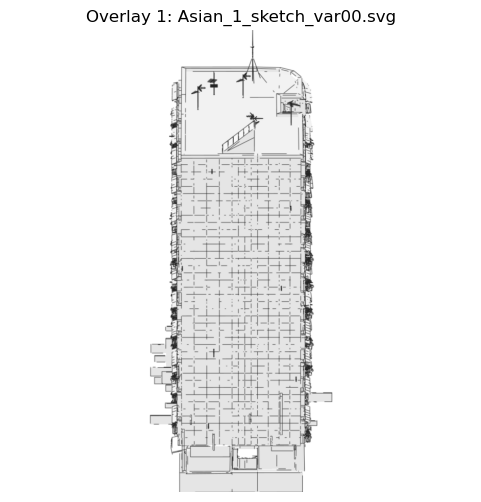

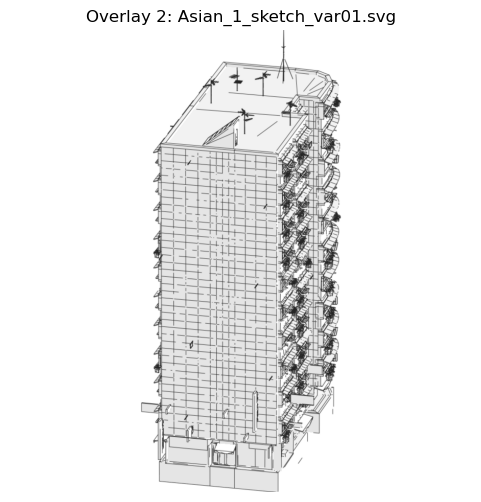

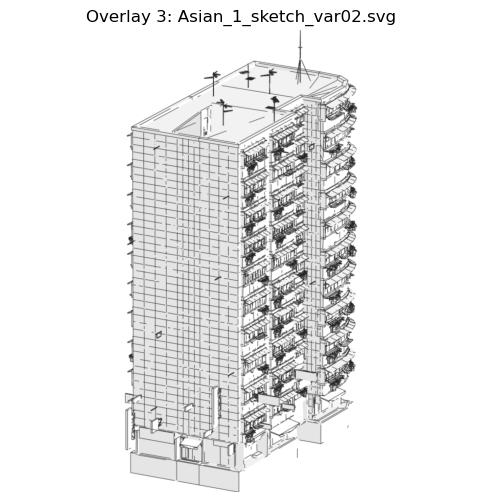

KeyboardInterrupt: 

In [108]:
import os
import re
import numpy as np
import cv2
import cairosvg
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# ==== Параметры пайплайна ====
SCALE_FACTOR   = 1.02
OFFSET_XY      = (-10, -10)       # (dx, dy)
SKETCH_ALPHA   = 0.85             # сила линий эскиза поверх
R_THRESH       = 200              # порог для каналов normal map
SHADE_STRENGTH = (0.1, 0.05, 0.0)  # веса вклада каналов (R,G,B) в серую тень
# ---------------------------------------------------------------

def _strip_namespace(svg_text: str) -> str:
    return svg_text.replace('xmlns="http://www.w3.org/2000/svg"', '')

def _remove_fill_from_style_attr(style: str) -> str:
    # убираем fill:... и fill-opacity:... из inline-style
    style = re.sub(r'fill\s*:\s*[^;]+;?', '', style, flags=re.IGNORECASE)
    style = re.sub(r'fill-opacity\s*:\s*[^;]+;?', '', style, flags=re.IGNORECASE)
    # подчистить возможные ;; и пробелы
    style = re.sub(r';{2,}', ';', style).strip().strip(';').strip()
    return style

def render_svg_to_bgra(svg_path, W, H):
    """
    Растеризует SVG в PNG с прозрачным фоном.
    - Удаляет фоновые <rect> (включая width/height=100%).
    - Удаляет ВСЕ заливки у элементов (оставляет только stroke).
    - Чистит fill в <style> и style="...".
    """
    with open(svg_path, 'r', encoding='utf-8') as f:
        svg_text = f.read()

    svg_text = _strip_namespace(svg_text)
    root = ET.fromstring(svg_text)

    # 1) подчистить <style> внутри svg (убрать fill в CSS)
    for style_node in root.findall('.//style'):
        if style_node.text:
            cleaned = re.sub(r'fill\s*:\s*[^;}\n]+;?', '', style_node.text, flags=re.IGNORECASE)
            cleaned = re.sub(r'fill-opacity\s*:\s*[^;}\n]+;?', '', cleaned, flags=re.IGNORECASE)
            style_node.text = cleaned

    # 2) удалить фоновые прямоугольники
    for rect in list(root.findall('.//rect')):
        w = rect.attrib.get('width', '').strip()
        h = rect.attrib.get('height', '').strip()
        has_fill = 'fill' in rect.attrib or ('style' in rect.attrib and re.search(r'fill\s*:', rect.attrib['style'], re.I))
        covers_all = (w in ('100%', '100') and h in ('100%', '100')) or (rect.attrib.get('x','0')=='0' and rect.attrib.get('y','0')=='0' and has_fill)
        if has_fill and (covers_all or True):  # чаще фоновый — любой залитый rect
            try:
                parent = root
                # найти реального родителя (ElementTree не хранит ссылку — делаем простой обход)
                stack = [root]
                while stack:
                    node = stack.pop()
                    for ch in list(node):
                        if ch is rect:
                            parent = node
                        stack.append(ch)
                parent.remove(rect)
            except Exception:
                pass  # если не удалось — просто оставим

    # 3) рекурсивно убрать все заливки у остальных элементов
    def strip_fills(node: ET.Element):
        # убираем fill атрибуты
        if 'fill' in node.attrib:
            node.set('fill', 'none')
        if 'fill-opacity' in node.attrib:
            node.set('fill-opacity', '0')
        # вычищаем fill из style
        if 'style' in node.attrib:
            style_clean = _remove_fill_from_style_attr(node.attrib['style'])
            if style_clean:
                node.set('style', style_clean)
            else:
                del node.attrib['style']
        for ch in list(node):
            strip_fills(ch)

    strip_fills(root)

    svg_clean = ET.tostring(root, encoding='utf-8').decode('utf-8')

    # 4) Растеризация с прозрачным фоном
    png_bytes = cairosvg.svg2png(
        bytestring=svg_clean.encode('utf-8'),
        output_width=W, output_height=H,
        background_color='rgba(0,0,0,0)'
    )
    img = cv2.imdecode(np.frombuffer(png_bytes, np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError('Failed to rasterize SVG')
    if img.shape[2] == 3:  # добавить альфу, если нет
        a = np.full(img.shape[:2], 255, np.uint8)
        img = np.dstack([img, a])
    return img

def warp_bgra(bgra, M, size):
    W, H = size
    rgb = bgra[:, :, :3]
    a   = bgra[:, :, 3]
    rgb_w = cv2.warpAffine(rgb, M, (W, H), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    a_w   = cv2.warpAffine(a,   M, (W, H), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.dstack([rgb_w, a_w])

def alpha_over(base_bgr, fg_bgra, fg_alpha_scale=1.0):
    base = base_bgr.astype(np.float32)
    fg_rgb = fg_bgra[:, :, :3].astype(np.float32)
    a = (fg_bgra[:, :, 3].astype(np.float32) / 255.0) * float(fg_alpha_scale)
    out = base * (1.0 - a[..., None]) + fg_rgb * a[..., None]
    return np.clip(out, 0, 255).astype(np.uint8)

def compute_shade_mask(nm, thresh, strength):
    """
    Серый фон с тенью: взвешенная сумма вкладов каналов normal map.
    strength: float или (R,G,B).
    """
    R = nm[:, :, 2].astype(np.float32)
    G = nm[:, :, 1].astype(np.float32)
    B = nm[:, :, 0].astype(np.float32)

    def norm(ch):
        return np.clip((ch - thresh) / max(1.0, (255.0 - thresh)), 0.0, 1.0)

    if np.isscalar(strength):
        sR = sG = sB = float(strength)
    else:
        sR, sG, sB = map(float, strength)

    shade_norm = sR*norm(R) + sG*norm(G) + sB*norm(B)     # 0..~1
    shade_norm = np.clip(shade_norm, 0.0, 1.0)
    shade = 1.0 - shade_norm
    base = (255.0 * shade)[..., None].repeat(3, axis=2).astype(np.uint8)
    return base

# ==== Основной код ====
if not sketch_to_nm:
    raise RuntimeError('No sketch/normal-map pairs detected')

for idx, (sketch_name, nm_name) in enumerate(list(sketch_to_nm.items())[:5]):
    svg_path = os.path.join(sketch_dir, sketch_name)
    nm_path  = os.path.join(normalmap_dir, nm_name)

    nm = cv2.imread(nm_path, cv2.IMREAD_COLOR)
    if nm is None:
        raise RuntimeError(f'Cannot read normal map: {nm_path}')
    H, W = nm.shape[:2]

    sketch_bgra = render_svg_to_bgra(svg_path, W, H)

    M = np.array([[SCALE_FACTOR, 0.0, OFFSET_XY[0]],
                  [0.0, SCALE_FACTOR, OFFSET_XY[1]]], dtype=np.float32)
    sketch_bgra = warp_bgra(sketch_bgra, M, (W, H))

    base_bgr = compute_shade_mask(nm, R_THRESH, SHADE_STRENGTH)

    out = alpha_over(base_bgr, sketch_bgra, fg_alpha_scale=SKETCH_ALPHA)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Overlay {idx+1}: {sketch_name}')
    plt.show()

### Textured Shadows (for unstability)

In [6]:
import os
import re
import numpy as np
import cv2
import cairosvg
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
def load_hatching_texture(path):
    tex = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if tex is None:
        raise RuntimeError(f'Не удалось загрузить текстуру: {path}')
    if tex.ndim == 3 and tex.shape[2] == 4:
        bgr = tex[:, :, :3]
        a   = tex[:, :, 3].astype(np.float32) / 255.0
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        # Композитим на белый фон через альфу (прозрачное -> белое)
        gray = gray * a + (1.0 - a)
        return (gray * 255.0).astype(np.uint8)
    elif tex.ndim == 3:
        return cv2.cvtColor(tex, cv2.COLOR_BGR2GRAY)
    else:
        return tex
    
hatching_tex_path = os.path.join('..', 'preprocessing', 'hatching_texture.png')
hatching_tex = load_hatching_texture(hatching_tex_path)
if hatching_tex is None:
    raise RuntimeError(f'Не удалось загрузить текстуру: {hatching_tex_path}')

# ==== Параметры пайплайна ====
SCALE_FACTOR   = 1.02
OFFSET_XY      = (-10, -10)       # (dx, dy)
SKETCH_ALPHA   = 0.85             # сила линий эскиза поверх
R_THRESH       = 200              # порог для каналов normal map
SHADE_STRENGTH = (1, 0.3, 0.0)  # веса вклада каналов (R,G,B) в серую тень
# ---------------------------------------------------------------

def _strip_namespace(svg_text: str) -> str:
    return svg_text.replace('xmlns="http://www.w3.org/2000/svg"', '')

def _remove_fill_from_style_attr(style: str) -> str:
    # убираем fill:... и fill-opacity:... из inline-style
    style = re.sub(r'fill\s*:\s*[^;]+;?', '', style, flags=re.IGNORECASE)
    style = re.sub(r'fill-opacity\s*:\s*[^;]+;?', '', style, flags=re.IGNORECASE)
    # подчистить возможные ;; и пробелы
    style = re.sub(r';{2,}', ';', style).strip().strip(';').strip()
    return style

def render_svg_to_bgra(svg_path, W, H):
    """
    Растеризует SVG в PNG с прозрачным фоном.
    - Удаляет фоновые <rect> (включая width/height=100%).
    - Удаляет ВСЕ заливки у элементов (оставляет только stroke).
    - Чистит fill в <style> и style="...".
    """
    with open(svg_path, 'r', encoding='utf-8') as f:
        svg_text = f.read()

    svg_text = _strip_namespace(svg_text)
    root = ET.fromstring(svg_text)

    # 1) подчистить <style> внутри svg (убрать fill в CSS)
    for style_node in root.findall('.//style'):
        if style_node.text:
            cleaned = re.sub(r'fill\s*:\s*[^;}\n]+;?', '', style_node.text, flags=re.IGNORECASE)
            cleaned = re.sub(r'fill-opacity\s*:\s*[^;}\n]+;?', '', cleaned, flags=re.IGNORECASE)
            style_node.text = cleaned

    # 2) удалить фоновые прямоугольники
    for rect in list(root.findall('.//rect')):
        w = rect.attrib.get('width', '').strip()
        h = rect.attrib.get('height', '').strip()
        has_fill = 'fill' in rect.attrib or ('style' in rect.attrib and re.search(r'fill\s*:', rect.attrib['style'], re.I))
        covers_all = (w in ('100%', '100') and h in ('100%', '100')) or (rect.attrib.get('x','0')=='0' and rect.attrib.get('y','0')=='0' and has_fill)
        if has_fill and (covers_all or True):  # чаще фоновый — любой залитый rect
            try:
                parent = root
                # найти реального родителя (ElementTree не хранит ссылку — делаем простой обход)
                stack = [root]
                while stack:
                    node = stack.pop()
                    for ch in list(node):
                        if ch is rect:
                            parent = node
                        stack.append(ch)
                parent.remove(rect)
            except Exception:
                pass  # если не удалось — просто оставим

    # 3) рекурсивно убрать все заливки у остальных элементов
    def strip_fills(node: ET.Element):
        # убираем fill атрибуты
        if 'fill' in node.attrib:
            node.set('fill', 'none')
        if 'fill-opacity' in node.attrib:
            node.set('fill-opacity', '0')
        # вычищаем fill из style
        if 'style' in node.attrib:
            style_clean = _remove_fill_from_style_attr(node.attrib['style'])
            if style_clean:
                node.set('style', style_clean)
            else:
                del node.attrib['style']
        for ch in list(node):
            strip_fills(ch)

    strip_fills(root)

    svg_clean = ET.tostring(root, encoding='utf-8').decode('utf-8')

    # 4) Растеризация с прозрачным фоном
    png_bytes = cairosvg.svg2png(
        bytestring=svg_clean.encode('utf-8'),
        output_width=W, output_height=H,
        background_color='rgba(0,0,0,0)'
    )
    img = cv2.imdecode(np.frombuffer(png_bytes, np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError('Failed to rasterize SVG')
    if img.shape[2] == 3:  # добавить альфу, если нет
        a = np.full(img.shape[:2], 255, np.uint8)
        img = np.dstack([img, a])
    return img

def warp_bgra(bgra, M, size):
    W, H = size
    rgb = bgra[:, :, :3]
    a   = bgra[:, :, 3]
    rgb_w = cv2.warpAffine(rgb, M, (W, H), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    a_w   = cv2.warpAffine(a,   M, (W, H), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.dstack([rgb_w, a_w])

def alpha_over(base_bgr, fg_bgra, fg_alpha_scale=1.0):
    base = base_bgr.astype(np.float32)
    fg_rgb = fg_bgra[:, :, :3].astype(np.float32)
    a = (fg_bgra[:, :, 3].astype(np.float32) / 255.0) * float(fg_alpha_scale)
    out = base * (1.0 - a[..., None]) + fg_rgb * a[..., None]
    return np.clip(out, 0, 255).astype(np.uint8)

def compute_hatching_mask(
    nm, thresh, strength, hatching_tex, *,
    scale=0.1,
    angles_deg=(-45.0, 45.0, 0.0),
    angle_spread=40.0,
    jitter_deg=6.0,
    scale_jitter=0.2,
    noise_strength=0.18,
    seed=None
):
    rng = np.random.default_rng(seed)

    # ----- веса каналов -----
    R = nm[:, :, 2].astype(np.float32)
    G = nm[:, :, 1].astype(np.float32)
    B = nm[:, :, 0].astype(np.float32)

    def norm(ch):
        return np.clip((ch - thresh) / max(1.0, (255.0 - thresh)), 0.0, 1.0)

    if np.isscalar(strength):
        sR = sG = sB = float(strength)
    else:
        sR, sG, sB = map(float, strength)

    wR = sR * norm(R)
    wG = sG * norm(G)
    wB = sB * norm(B)
    shade_norm = np.clip(wR + wG + wB, 0.0, 1.0)

    wsum = wR + wG + wB + 1e-6
    wR_n, wG_n, wB_n = wR/wsum, wG/wsum, wB/wsum

    H, W = nm.shape[:2]

    # ---- helpers ----
    def _tiled(tex, target_w, target_h, base_scale):
        th, tw = tex.shape[:2]
        s = max(1e-6, base_scale * (1.0 + rng.uniform(-scale_jitter, scale_jitter)))
        new_w = max(1, int(tw * s))
        new_h = max(1, int(th * s))
        small = cv2.resize(tex, (new_w, new_h), interpolation=cv2.INTER_AREA)
        reps_x = int(np.ceil(target_w / new_w)) + 1
        reps_y = int(np.ceil(target_h / new_h)) + 1
        tiled = np.tile(small, (reps_y, reps_x))
        return tiled[:target_h, :target_w]

    def _rotated_tiled(base_tex, angle_deg):
        # Сначала тайлим на весь кадр
        tiled = _tiled(base_tex, W, H, scale).astype(np.float32) / 255.0
        # Затем крутим всю плоскость с заворачиванием границ (без белых углов)
        ang = float(angle_deg) + rng.normal(0.0, jitter_deg)
        M = cv2.getRotationMatrix2D((W*0.5, H*0.5), ang, 1.0)
        # Случайный сдвиг для «texture paint»
        M[0, 2] += rng.uniform(-W*0.5, W*0.5)
        M[1, 2] += rng.uniform(-H*0.5, H*0.5)
        return cv2.warpAffine(
            tiled, M, (W, H),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_WRAP   # <- главное изменение
        )

    half = angle_spread * 0.5
    ax_lo, ay_lo, az_lo = [a - half for a in angles_deg]
    ax_hi, ay_hi, az_hi = [a + half for a in angles_deg]

    # две ориентации для каждой оси
    tex_x_lo = _rotated_tiled(hatching_tex, ax_lo)
    tex_x_hi = _rotated_tiled(hatching_tex, ax_hi)
    tex_y_lo = _rotated_tiled(hatching_tex, ay_lo)
    tex_y_hi = _rotated_tiled(hatching_tex, ay_hi)
    tex_z_lo = _rotated_tiled(hatching_tex, az_lo)
    tex_z_hi = _rotated_tiled(hatching_tex, az_hi)

    # интерполяция угла по силе тени
    tex_x = tex_x_lo * (1.0 - shade_norm) + tex_x_hi * shade_norm
    tex_y = tex_y_lo * (1.0 - shade_norm) + tex_y_hi * shade_norm
    tex_z = tex_z_lo * (1.0 - shade_norm) + tex_z_hi * shade_norm

    # смешение по направлениям нормали
    hatch = wR_n * tex_x + wG_n * tex_y + wB_n * tex_z  # 0..1

    # «hand-drawn» зерно
    if noise_strength > 0:
        noise = rng.random((H, W)).astype(np.float32)
        noise = cv2.GaussianBlur(noise, (0, 0), sigmaX=1.2, sigmaY=1.2)
        hatch = np.clip(hatch * (1.0 - 0.5*noise_strength + noise_strength*noise), 0.0, 1.0)

    # чем больше shade_norm — тем темнее (сильнее проявляем штрихи)
    out_gray = 1.0 - shade_norm * (1.0 - hatch)
    out_gray = np.clip(out_gray * 255.0, 0, 255).astype(np.uint8)
    return cv2.merge([out_gray, out_gray, out_gray])

# ==== Основной код ====
if not sketch_to_nm:
    raise RuntimeError('No sketch/normal-map pairs detected')

for idx, (sketch_name, nm_name) in enumerate(list(sketch_to_nm.items())[391:]):
    
    # Show a loading bar using idx to indicate progress
    import sys

    total = len(sketch_to_nm)-391
    bar_len = 100
    progress = (idx + 1) / total
    filled_len = int(bar_len * progress)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    print(f"\rProcessing [{bar}] {idx+1}/{total}", end='', flush=True)
    if idx + 1 == total:
        print()  # Move to next line after last
        
    svg_path = os.path.join(sketch_dir, sketch_name)
    nm_path  = os.path.join(normalmap_dir, nm_name)

    nm = cv2.imread(nm_path, cv2.IMREAD_COLOR)
    if nm is None:
        raise RuntimeError(f'Cannot read normal map: {nm_path}')
    H, W = nm.shape[:2]

    sketch_bgra = render_svg_to_bgra(svg_path, W, H)

    M = np.array([[SCALE_FACTOR, 0.0, OFFSET_XY[0]],
                  [0.0, SCALE_FACTOR, OFFSET_XY[1]]], dtype=np.float32)
    sketch_bgra = warp_bgra(sketch_bgra, M, (W, H))

    base_bgr = compute_hatching_mask(
        nm, R_THRESH, SHADE_STRENGTH,
        hatching_tex=hatching_tex,
        scale=0.3,
        angles_deg=(-5, 5, 0),   # X->R, Y->G, Z->B
        angle_spread=40,           # насколько «крутить» при strength→1
        jitter_deg=6,
        scale_jitter=0.1,
        noise_strength=0.2,
        seed=42
    )

    out = alpha_over(base_bgr, sketch_bgra, fg_alpha_scale=SKETCH_ALPHA)

    # Save the output image to ../dataset/shadowed_sketches/
    out_dir = os.path.join("..", "dataset", "shadowed_sketches")
    os.makedirs(out_dir, exist_ok=True)
    out_name = os.path.splitext(sketch_name.replace("sketch", "shad_sketch"))[0] + ".png"
    out_path = os.path.join(out_dir, out_name)
    cv2.imwrite(out_path, out)
    

Processing [====================================================================================================] 384/384
